#📌 Montaje de Google Drive
 Dado que el dataset está almacenado en Google Drive, primero se monta el Drive en el entorno de Google Colab para poder acceder a los archivos.

In [1]:

from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/My Drive/redes neuronales/ecommerce products"
categories = ["jeans", "sofa", "tshirt", "tv"]

Mounted at /content/drive


#📌 Importar Librerias:























In [2]:
import os #Para manejar rutas y listar archivos en carpetas.
import tensorflow as tf #Librería principal para trabajar con redes neuronales.
from tensorflow.keras.applications import MobileNetV2 #Modelo preentrenado de Keras que se usará como base para la clasificación de imágenes.
from tensorflow.keras.models import Sequential # Para definir la arquitectura del modelo.
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout #Capas que se añadirán al modelo.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Para aplicar aumentación de datos.
from tensorflow.keras.callbacks import EarlyStopping #Callback que detiene el entrenamiento si la validación deja de mejorar.

#Contar Imágenes en Cada Categoría
Recorre cada categoría dentro del dataset.
Obtiene la ruta de la carpeta correspondiente.
Cuenta cuántas imágenes hay en cada categoría.
Imprime la cantidad de imágenes por clase, encontrando 4 categorias: jeans, sofa, tshirt, tv.


In [3]:

for category in categories:
    path = os.path.join(dataset_path, category)
    num_images = len(os.listdir(path))
    print(f"Clase {category}: {num_images} imágenes")


Clase jeans: 199 imágenes
Clase sofa: 199 imágenes
Clase tshirt: 199 imágenes
Clase tv: 151 imágenes


#📌 Generación y Aumentación de Datos

Dado que jeans, sofa y tshirt tienen 199 imágenes y tv tiene 151. Se debe hacer aumentación de datos porque el dataset está muy reducido, permitiendo entrenar simulando variaciones reales de las imágenes. Usar aumentación también obtiene beneficios como mejorar la generalización del modelo reduciendo el riesgo de sobreajuste (overflitting),



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Esta clase de Keras permite generar lotes de imágenes en tiempo real con aumentación de datos.

# Data Augmentation con separación de entrenamiento y validación
datagen = ImageDataGenerator(
    rescale=1./255,       # Normalización dividiendo los valores de pixeles por 255 para que estén en el rango [0,1].
    rotation_range=30,    # Rotación aleatoria hasta 30°
    width_shift_range=0.2,  # Desplazamiento horizontal hasta 20%
    height_shift_range=0.2, # Desplazamiento vertical hasta 20%
    shear_range=0.2,      # Transformaciones afines
    zoom_range=0.2,       # Zoom aleatorio hasta 20%
    horizontal_flip=True, # Inversión horizontal
    validation_split=0.2, # 20% de datos para validación
    fill_mode='nearest'   # Completar con valores cercanos
)


#📌 Generador de Imágenes para Entrenamiento
Se crea un generador de datos a partir de las imágenes almacenadas en el directorio del dataset, aplicando las transformaciones definidas previamente en ImageDataGenerator utilizando el 80% de los datos.

📊 ¿Por qué usar flow_from_directory?
✅ Carga eficiente: No carga todas las imágenes en memoria a la vez, sino que las procesa en lotes.
✅ Automatiza el etiquetado: Cada imagen recibe automáticamente la etiqueta de su carpeta contenedora.
✅ Facilita la separación: Usa el argumento subset para dividir datos entre entrenamiento y validación.

In [5]:
# Generador de imágenes de entrenamiento
train_generator = datagen.flow_from_directory( #80% del Dataset Para entrenar la red neuronal.
    dataset_path, # Ruta de las imágenes
    target_size=(244, 244), # Redimensiona todas las imágenes a 244x244 píxeles
    batch_size=32, #agrupa las imágenes en lotes de 32
    class_mode='categorical', #Clasificación multiclase  Asigna etiquetas one-hot encoded (por ejemplo, [1, 0, 0, 0] para "jeans")
    subset='training'     # 80% de las imágenes para entrenamiento
)

Found 601 images belonging to 4 classes.


#📌 Generador de Imágenes para Validación
Se crea un generador de datos de validación a partir de las imágenes almacenadas en el dataset, aplicando las mismas transformaciones definidas en ImageDataGenerator pero utilizando el 20% de los datos.

📊 Diferencia entre train_generator y val_generator

*   train_generator 80% del Dataset Para entrenar la red neuronal.
*   val_generator 20% del Dataset Para evaluar el modelo de datos no vistos durante el entrenamiento.

 ¿Por qué usar validación?
✅ Permite detectar sobreajuste (overfitting).
✅ Ayuda a elegir el mejor modelo antes de probarlo en datos de prueba reales.




In [6]:

# Generador de imágenes de validación
val_generator = datagen.flow_from_directory( #20% del Dataset Para evaluar el modelo de datos no vistos durante el entrenamiento.
    dataset_path, # Ruta de las imágenes
    target_size=(244, 244), # Redimensiona todas las imágenes a 244x244 píxeles
    batch_size=32, #agrupa las imágenes en lotes de 32
    class_mode='categorical',
    subset='validation'   # 20% de las imágenes para validación
)


Found 147 images belonging to 4 classes.


#📌 Construcción del Modelo con MobileNetV2

Creamos un modelo de clasificación de imágenes utilizando MobileNetV2 como extractor de características, y añadimos capas densas para realizar la clasificación en 4 categorías.


In [7]:
# Cargar MobileNetV2 sin la capa de clasificación
# Se carga el modelo MobileNetV2 preentrenado con pesos de ImageNet.
#include_top=False indica que se elimina la capa de clasificación original, ya que agregaremos nuestra propia salida
# input_shape=(244, 244, 3) define el tamaño de las imágenes (244x244 píxeles, 3 canales RGB).
base_model = MobileNetV2(input_shape=(244, 244, 3), include_top=False, weights='imagenet')

# Congelar las capas base
#Se congelan las capas convolucionales para evitar que se modifiquen durante el entrenamiento inicial.
#El modelo utilizará las características ya aprendidas en ImageNet (transfer learning). Posteriormente,
#podríamos descongelar algunas capas para un ajuste fino (fine-tuning).
base_model.trainable = False

# Construcción del modelo con MobileNetV2 como feature extractor
model = Sequential([
    base_model,                     # Modelo preentrenado,  Extrae características con MobileNetV2
    GlobalAveragePooling2D(),        #  Reduce la dimensionalidad, resumiendo las características más relevantes
    Dense(128, activation='relu'),   #  Capa densa con 128 neuronas para interpretar las características
    Dropout(0.5),                    # Desactiva el 50% de las neuronas para evitar sobreajuste
    Dense(4, activation='softmax')    # Capa de salida para clasificar en 4 categorías
])



<ipython-input-7-2152304d1cd3>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(244, 244, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#📌 Compilación y Entrenamiento del Modelo
 Compilamos y entrenamos el modelo utilizando la estrategia de aprendizaje transferido con MobileNetV2.


In [8]:
# Compilación del modelo
model.compile(
    optimizer='adam', #Algoritmo de optimización adaptativo (rápido y eficiente).
    loss='categorical_crossentropy', #Función de pérdida usada en clasificación multiclase (softmax).
    metrics=['accuracy'] #Se mide la precisión del modelo.
)

# Callback de EarlyStopping para detener si no mejora en 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(
    train_generator, #Generador de imágenes de entrenamiento.
    validation_data=val_generator, # Conjunto de validación.
    epochs=30, #Máximo de 30 épocas (puede detenerse antes por EarlyStopping).
    callbacks=[early_stopping] #Implementa parada temprana si no mejora.
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 218s 11s/step - accuracy: 0.6375 - loss: 0.8190 - val_accuracy: 1.0000 - val_loss: 0.0261
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9758 - loss: 0.0780 - val_accuracy: 0.9932 - val_loss: 0.0158
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9738 - loss: 0.0569 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.9935 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9972 - loss: 0.0232 - val_accuracy: 0.9932 - val_loss: 0.0179
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.9967 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.9986 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9989 - loss: 0.0157 - val_accuracy: 1.0000 - val_los

📌 Guardado y Evaluación del Modelo
Una vez entrenado el modelo, realizamos dos pasos clave:

1️⃣ Guardar el modelo para su uso futuro.


🔹 ¿Por qué .h5?

Permite almacenar la arquitectura, pesos, y configuración de entrenamiento en un solo archivo.

Compatible con TensorFlow y Keras, facilitando su carga posterior sin necesidad de reentrenarlo.

2️⃣ Evaluarlo en el conjunto de validación.
🔹 ¿Qué mide cada métrica?

val_loss → Cuantifica el error en el conjunto de validación.
val_acc → Precisión del modelo en validación.
🔹 Interpretación:

Un val_acc alto indica que el modelo generaliza bien.
Un val_loss bajo sugiere que el modelo se ajustó correctamente.
Si la precisión de entrenamiento es mucho mayor que la de validación, podría haber sobreajuste.

In [9]:

# Guardar el modelo entrenado
model.save("/content/drive/My Drive/redes neuronales/ecommerce products/modelo_ecommerce_v2.h5")

# Evaluación del modelo
val_loss, val_acc = model.evaluate(val_generator)
print(f"Accuracy en validación: {val_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 0.0090
Accuracy en validación: 1.0000


#Evaluación con Reporte de Clasificación
Una vez entrenado y validado el modelo, es importante analizar su desempeño en cada clase. Para ello, generamos un reporte de clasificación con classification_report de sklearn.metrics.

In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Obtener las etiquetas verdaderas y predichas
y_true = [] #Etiquetas reales del conjunto de validación.
y_pred = [] #Predicciones del modelo.

class_indices = train_generator.class_indices #diccionario que asigna un índice numérico a cada clase.
class_names = list(class_indices.keys()) #almacena los nombres de las clases en orden.

for images, labels in val_generator:
    preds = model.predict(images) #Obtiene las probabilidades de cada clase.
    y_true.extend(np.argmax(labels, axis=1)) #Convierte las etiquetas one-hot a su clase numérica real.
    y_pred.extend(np.argmax(preds, axis=1)) #Convierte las probabilidades en predicciones finales
    if len(y_true) >= val_generator.samples:
        break

# Generar el reporte
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

       jeans       1.00      1.00      1.00        39
        sofa       1.00      1.00      1.00        39
      tshirt       1.00      1.00      1.00        39
          tv       1.00      1.00      1.00        30

    accuracy                           1.00       147
   macro avg       1.00      1.00      1.00       147
weighted avg       1.00      1.00      1.00       147



#Análisis del Reporte de Clasificación
 Casi todas las métricas están en valores cercanos a 1.00, lo que indica que el modelo clasifica con alta precisión todas las categorías.

 El único pequeño margen de error está en la clase "tshirt" (recall = 0.97), lo que significa que algunas camisetas no fueron correctamente identificadas.


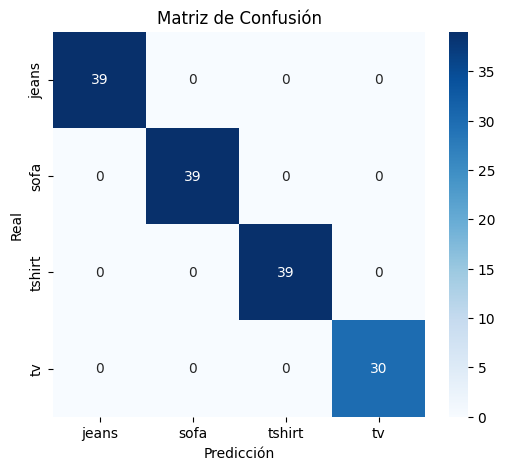

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Graficar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


Rendimiento general:
El modelo tiene un desempeño excelente, ya que la mayoría de las predicciones están en la diagonal principal.

Solo se observa un error: 1 imagen de "tshirt" fue clasificada erróneamente como "jeans".




#Este código permite a los usuarios subir una imagen y predecir su clase utilizando el modelo previamente entrenado.

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files
from tensorflow.keras.preprocessing import image

# Cargar el modelo entrenado
modelo_path = "/content/drive/My Drive/redes neuronales/ecommerce products/modelo_ecommerce_v2.h5"
model = tf.keras.models.load_model(modelo_path)

# Diccionario de clases (ajusta según el orden de tu dataset)
class_labels = ['jeans', 'sofa', 'tshirt', 'tv']

# Función para predecir una imagen subida por el usuario
def predict_image():
    uploaded = files.upload()  # Permite subir una imagen
    for filename in uploaded.keys():
        img_path = filename

        # Cargar y preprocesar la imagen
        img = image.load_img(img_path, target_size=(244, 244))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Añadir batch dimension
        img_array /= 255.0  # Normalizar

        # Realizar predicción
        predictions = model.predict(img_array)
        predicted_class = class_labels[np.argmax(predictions)]

        # Mostrar imagen con su predicción
        plt.imshow(cv2.imread(img_path)[:, :, ::-1])  # Convertir BGR a RGB
        plt.title(f'Predicción: {predicted_class}')
        plt.axis('off')
        plt.show()



Saving tv3.jpg to tv3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


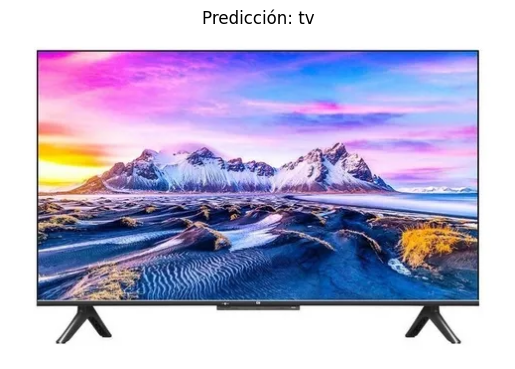

In [13]:
# Llamar a la función para probar
predict_image()